In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azureml-dataprep-rslex 1.14.0 (c:\users\amah\.conda\envs\amlcomponentsdk\lib\site-packages), Requirement.parse('azureml-dataprep-rslex<1.14.0a,>=1.13.0dev0'), {'azureml-dataprep'}).


SDK version: 1.27.0.post36812463


In [2]:
import os
import azureml.core
from azureml.core import Workspace, Experiment, Datastore, Environment
# from azureml.widgets import RunDetails
from azureml.core.authentication import InteractiveLoginAuthentication

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)
interactive_auth = InteractiveLoginAuthentication(tenant_id="dadbf9da-3f3b-44a8-8097-f3512ff34da8")
ws = Workspace.from_config(auth=interactive_auth)
# ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

# def_blob_store = ws.get_default_datastore()
def_blob_store = Datastore(ws, "workspaceblobstore")
print("Blobstore's name: {}".format(def_blob_store.name))

SDK version: 1.25.0
Workspace name: fin-ws-wus2
Azure region: westus2
Subscription id: 63a4bc7f-cd60-49a3-b139-49202d485eac
Resource group: fin-research
Blobstore's name: workspaceblobstore


In [3]:
from azureml.data.data_reference import DataReference
from azureml.pipeline.core import Pipeline, PipelineData, PipelineParameter
from azureml.pipeline.steps import PythonScriptStep
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core import (
    RunConfiguration,
    ScriptRunConfig,
    Experiment,
    Environment,
    Dataset,
    Datastore,
    Workspace,
)

print("Pipeline SDK-specific imports completed")


Pipeline SDK-specific imports completed


In [4]:
gpu_cluster_name = "gpu-cluster"

try:
    gpu_compute_target = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=1)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    gpu_compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


In [5]:
# cpu_cluster_name = "cpu-cluster2"
cpu_cluster_name = "CPU-D13V2"

try:
    cpu_compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D11_V2', 
                                                           max_nodes=1)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    cpu_compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


In [6]:
from azureml.core.dataset import Dataset
def_data_store = ws.get_default_datastore()

input_data_dataset = Dataset.File.from_files((def_data_store, 'datasets/data_mp_1000_0.0005'), validate=True)

# Setup environments

In [7]:
from azureml.core import Environment
from azureml.core.runconfig import CondaDependencies, DEFAULT_CPU_IMAGE

data_process_conda_deps = CondaDependencies.create(pip_packages=["pandas", 
                                                          "azureml-core", "azureml-dataset-runtime[fuse]", "tqdm", "sklearn"])
cpu_env = Environment(name="cpu_environment")
cpu_env.python.conda_dependencies = data_process_conda_deps
cpu_env.docker.enabled = True
cpu_env.docker.base_image = DEFAULT_CPU_IMAGE

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [8]:
tf_keras_env = Environment.from_conda_specification(name='tensorflow-keras-2.0-gpu', file_path='../curated_env_packages/conda_dependencies.yml')
tf_keras_env.docker.enabled = True
tf_keras_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'
# from azureml.core.runconfig import DEFAULT_GPU_IMAGE
# tf_keras_env.docker.base_image = DEFAULT_GPU_IMAGE

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


# Pipeline Paramters

In [9]:
pt_level = 0.0010
vol_tick = 1000
time_steps = 100

In [10]:
pt_sl_level_param = PipelineParameter(name="pt_sl_level", default_value=pt_level)
vol_tick_param = PipelineParameter(name="vol_tick", default_value=vol_tick)


### Intermediate/Output Data
Intermediate data (or output of a Step) is represented by [PipelineData](https://docs.microsoft.com/en-us/python/api/azureml-pipeline-core/azureml.pipeline.core.pipelinedata?view=azure-ml-py) object. PipelineData can be produced by one step and consumed in another step by providing the PipelineData object as an output of one step and the input of one or more steps.


In [11]:
from azureml.data import OutputFileDatasetConfig

output_path = "datasets/trained_models"
# output_data_ref = OutputFileDatasetConfig(
#     destination=(def_data_store, output_path), name="model_out"
# )
quotes_dataset = Dataset.File.from_files(
    (def_data_store, "datasets/quotes_merged_mp/"), validate=True
)
trades_dataset = Dataset.File.from_files(
    (def_data_store, "datasets/trades_merged_mp/"), validate=True
)




bars_data = OutputFileDatasetConfig(name=f"bars_data_{pt_level}_{vol_tick}".replace('.','_')).register_on_complete(f"bars_data_{pt_level}_{vol_tick}".replace('.','_'))
training_input_data = OutputFileDatasetConfig(name=f"training_input_data_{pt_level}_{vol_tick}".replace('.','_')).register_on_complete(f"training_input_data_{pt_level}_{vol_tick}".replace('.','_'))
testing_input_data = OutputFileDatasetConfig(name=f"testing_input_data_{pt_level}_{vol_tick}".replace('.','_')).register_on_complete(f"testing_input_data_{pt_level}_{vol_tick}".replace('.','_'))
training_lstm_input_data = OutputFileDatasetConfig(name=f"training_lstm_input_data_{pt_level}_{vol_tick}_{time_steps}".replace('.','_')).register_on_complete(f"training_lstm_input_data_{pt_level}_{vol_tick}_{time_steps}".replace('.','_'))
testing_lstm_input_data = OutputFileDatasetConfig(name=f"testing_lstm_input_data_{pt_level}_{vol_tick}_{time_steps}".replace('.','_')).register_on_complete(f"testing_lstm_input_data_{pt_level}_{vol_tick}_{time_steps}".replace('.','_'))

output_model = OutputFileDatasetConfig(name=f"lstm_model_{pt_level}_{vol_tick}".replace('.','_')).register_on_complete(f"lstm_model_{pt_level}_{vol_tick}".replace('.','_'))
# PipelineData(f"training_input_data_{pt_level}_{vol_tick}".replace('.','_'), datastore=def_blob_store).as_dataset()

# Process/Train Pipline 

## Data Prep

In [12]:
args = [
    "--sample_days",
   -1,
    "--pt_level",
    pt_level,
    "--sl_level",
    pt_level,
    "--vol_tick",
    vol_tick,
    "--wait_time",
    "600",
    "--quotes_path",
    quotes_dataset.as_mount(),
    "--trades_path",
    trades_dataset.as_mount(),
    "--data_output",
    bars_data
]
script_folder = "../modules/dataprep/"

run_config = RunConfiguration()
run_config.environment = cpu_env

dataprep_step = PythonScriptStep(
    name="Data Prep",
    script_name="run.py",
    arguments=args,
    inputs=[quotes_dataset.as_mount(), trades_dataset.as_mount()],
    outputs=[bars_data],
    compute_target=cpu_compute_target,
    source_directory=script_folder,
    runconfig=run_config,
)

In [13]:
pipeline_1 = Pipeline(workspace=ws, steps=[dataprep_step])
print ("Pipeline is built")

Pipeline is built


In [14]:
pipeline_run1 = Experiment(ws, 'fin_pipeline').submit(pipeline_1)
print("Pipeline is submitted for execution")

Created step Data Prep [074d5f6a][29f40f40-a6bd-420f-b481-ffda4fb2c219], (This step will run and generate new outputs)
Submitted PipelineRun a177e939-ffa1-4e20-a32c-5546c0c5d581
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/a177e939-ffa1-4e20-a32c-5546c0c5d581?wsid=/subscriptions/63a4bc7f-cd60-49a3-b139-49202d485eac/resourcegroups/fin-research/workspaces/fin-ws-wus2&tid=dadbf9da-3f3b-44a8-8097-f3512ff34da8
Pipeline is submitted for execution


## Feature Extraction

In [17]:
bars_dataset = Dataset.get_by_name(ws,f"bars_data_{pt_level}_{vol_tick}".replace('.','_'))
bars_dataset

{
  "source": [
    "('workspaceblobstore', 'dataset/8dcbb452-f72f-45fd-89ee-74e723b5e781/bars_data_0_001_1000/')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "a2c2305c-89a8-4599-b91e-6dbc8489bd75",
    "name": "bars_data_0_001_1000",
    "version": 5,
    "workspace": "Workspace.create(name='fin-ws-wus2', subscription_id='63a4bc7f-cd60-49a3-b139-49202d485eac', resource_group='fin-research')"
  }
}

In [34]:
args = [
    "--sample_days",
    -1,
    "--time_steps",
    time_steps,
    "--input_data",
    bars_dataset.as_mount(),
#     bars_data,
    "--output_train_data",
    training_input_data,
    "--output_test_data",
    testing_input_data,
    "--output_LSTM_train_data",
    training_lstm_input_data,
    "--output_LSTM_test_data",
    testing_lstm_input_data,
]
script_folder = "../modules/feature_extraction/"

run_config = RunConfiguration()
run_config.environment = cpu_env

feature_extraction_step = PythonScriptStep(
    name="Feature Extraction",
    script_name="run.py",
    arguments=args,
    inputs=[bars_dataset.as_mount()],
#     inputs=[bars_data],
    outputs=[training_input_data, testing_input_data],
    compute_target=cpu_compute_target,
    source_directory=script_folder,
    runconfig=run_config,
)

In [35]:
pipeline_1 = Pipeline(workspace=ws, steps=[feature_extraction_step])
print ("Pipeline is built")

Pipeline is built


In [36]:
pipeline_run1 = Experiment(ws, 'fin_pipeline').submit(pipeline_1)
print("Pipeline is submitted for execution")

Created step Feature Extraction [00a86ba8][0dd84576-388e-4e94-8a02-0777e2250e09], (This step will run and generate new outputs)
Submitted PipelineRun 638dc9e1-7e15-4083-ac40-da38339b7aa0
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/638dc9e1-7e15-4083-ac40-da38339b7aa0?wsid=/subscriptions/63a4bc7f-cd60-49a3-b139-49202d485eac/resourcegroups/fin-research/workspaces/fin-ws-wus2&tid=dadbf9da-3f3b-44a8-8097-f3512ff34da8
Pipeline is submitted for execution


## Training

In [29]:
from azureml.core import ScriptRunConfig

# args = ['--data-folder', dataset.as_mount(),
#         '--batch-size', 64,
#         '--first-layer-neurons', 256,
#         '--second-layer-neurons', 128,
#         '--learning-rate', 0.01]
train_args = ['--sample_data_size', -1,
       '--input_data', training_lstm_input_data,    
       '--output_model', output_model,
       "--epochs", 20]
script_folder = '../modules/train'
gpu_run_config = RunConfiguration()
gpu_run_config.environment = tf_keras_env

train_step = PythonScriptStep(
    name = 'Train',
    script_name="run.py", 
    arguments=train_args,
    inputs=[training_lstm_input_data],
    outputs=[output_model],
    compute_target=gpu_compute_target, 
    source_directory=script_folder,
    runconfig=gpu_run_config
)



## Pipeline Definition

In [30]:
pipeline_1 = Pipeline(workspace=ws, steps=[feature_extraction_step, train_step])
print ("Pipeline is built")

Pipeline is built


In [31]:
pipeline_1.validate()

Step Feature Extraction is ready to be created [4c38223b]Step Train is ready to be created [18a992ec]



[]

In [32]:
pipeline_run1 = Experiment(ws, 'fin_pipeline').submit(pipeline_1)
print("Pipeline is submitted for execution")

Created step Feature Extraction [4c38223b][3f3025eb-d32c-4c4e-ad34-b83291c624b4], (This step will run and generate new outputs)
Created step Train [18a992ec][599b7e3e-fc2d-4492-bf22-538d018e73e5], (This step will run and generate new outputs)
Submitted PipelineRun aa985ce7-d076-4e28-b0b9-e1cb56bc9496
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/fin_pipeline/runs/aa985ce7-d076-4e28-b0b9-e1cb56bc9496?wsid=/subscriptions/63a4bc7f-cd60-49a3-b139-49202d485eac/resourcegroups/fin-research/workspaces/fin-ws-wus2
Pipeline is submitted for execution


In [25]:
import pandas as pd


In [26]:
df_bars = pd.read_csv("../data/test_label_mp_local/bars_2020-07-28-mt.csv")

# df_bars = pd.read_csv("../data/test_label_mp_local/bars_2017-01-06-mt.csv")
# df_TW_avg = pd.read_csv("../data/test_label_mp_local/TW_2017-01-06-mt.csv")

In [27]:
df_bars.head()

,Ask Price,Ask Size,Bid Price,Bid Size,Spread,Mid Quote,Smart Price,Quote Imbalance,Ask Price_diff_1,Ask Size_diff_1,...,long_return_3,long_duration_3,pt_long_ind_3,sl_long_ind_3,short_label_3,short_return_3,short_duration_3,pt_short_ind_3,sl_short_ind_3,end_ind_3
0,3223.50,163.0,3223.25,300.0,0.25,3223.375,3223.411987,-0.610032,NaN,NaN,...,1.50,0 days 00:10:00.003520750,NaN,NaN,0.0,-1.50,0 days 00:10:00.003520750,NaN,NaN,58867.0
1,3224.00,1174.0,3223.75,360.0,0.25,3223.875,3223.808670,1.182068,0.50,1011.0,...,0.75,0 days 00:10:00.000795193,NaN,NaN,0.0,-0.75,0 days 00:10:00.000795193,NaN,NaN,59007.0
2,3224.75,7.0,3224.50,77.0,0.25,3224.625,3224.729167,-2.397895,0.75,-1167.0,...,-0.50,0 days 00:10:00.001022539,NaN,NaN,0.0,0.50,0 days 00:10:00.001022539,NaN,NaN,59088.0
3,3226.50,35.0,3226.25,312.0,0.25,3226.375,3226.474784,-2.187655,1.75,28.0,...,-2.25,0 days 00:10:00.058802470,NaN,NaN,0.0,2.25,0 days 00:10:00.058802470,NaN,NaN,59137.0
4,3226.00,64.0,3225.75,32.0,0.25,3225.875,3225.833333,0.693147,-0.50,29.0,...,-1.75,0 days 00:10:00.015978338,NaN,NaN,0.0,1.75,0 days 00:10:00.015978338,NaN,NaN,59207.0


In [36]:
keys = ["Ask Price", "Ask Size", "Bid Price", "Bid Size"]
TW_avg_keys = ["TW Avg " + key for key in keys]
df_bars = pd.concat(
    [df_bars, df_TW_avg[TW_avg_keys]], axis=1
)

In [37]:
df_bars.head()

,original_index,Date-Time,Bid Price,Ask Price,Bid Size,Ask Size,Seq. No.,Exch Time,#RIC,dailyVolatility,...,sl_long_ind,pt_short_ind,sl_short_ind,end_ind,long_label,short_label,TW Avg Ask Price,TW Avg Ask Size,TW Avg Bid Price,TW Avg Bid Size
0,89,2017-01-06 08:30:00.140785204-06:00,2264.50,2264.75,3.0,661.0,9512845,14:30:00.129000000,ESH7,1.098048,...,91.0,90.0,494.0,39417.0,-1,1,2264.755058,907.407278,2264.505175,2839.812089
1,116,2017-01-06 08:30:00.194000527-06:00,2264.00,2264.50,1372.0,986.0,9513099,14:30:00.178000000,ESH7,1.098048,...,4132.0,118.0,250.0,39428.0,1,1,2264.500436,1062.044695,2264.250771,2464.645255
2,245,2017-01-06 08:30:00.501194459-06:00,2264.25,2264.50,1901.0,2304.0,9514161,14:30:00.494000000,ESH7,1.098048,...,4056.0,4055.0,250.0,39446.0,1,-1,2264.304450,1346.295101,2264.053743,1275.910291
3,491,2017-01-06 08:30:01.877325218-06:00,2264.50,2264.75,1420.0,367.0,9515656,14:30:01.869000000,ESH7,1.098048,...,4020.0,4019.0,494.0,39520.0,1,-1,2264.747062,1214.322293,2264.497123,577.565675
4,961,2017-01-06 08:30:07.051324573-06:00,2265.25,2265.50,293.0,4582.0,9517830,14:30:06.641000000,ESH7,1.098048,...,2824.0,2824.0,1114.0,39747.0,1,-1,2265.096555,826.370207,2264.846582,757.826852


In [209]:
df2 = pd.concat([df[['pt_short_ind', 'sl_short_ind']],df[['long_label', 'short_label']]], axis=1)
df2.head()

,pt_short_ind,sl_short_ind,long_label,short_label
0,1211.0,NaN,-1,1
1,3022.0,NaN,-1,1
2,3664.0,4059.0,-1,1
3,5718.0,5467.0,-1,-1
4,6366.0,6208.0,1,-1


In [21]:
date_string = str(df.loc[0, 'Date-Time'])[:10]
date_string

'2017-01-03'

In [39]:
df["Date-Time"]=pd.to_datetime(df["Date-Time"])

In [40]:
datetime.strptime(f"{date_string} 8: 30 -0600", "%Y-%m-%d %H: %M %z")

datetime.datetime(2017, 1, 3, 8, 30, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=64800)))

In [41]:
from datetime import datetime
print("full df shape", df.shape)
df = df[df['Date-Time'] >= datetime.strptime(f"{date_string} 8: 30 -0600", "%Y-%m-%d %H: %M %z")]
print(">8:30 df shape", df.shape)
df= df[df['Date-Time'] <= datetime.strptime(f"{date_string} 13: 15 -0600", "%Y-%m-%d %H: %M %z")]
print(">8:30 < 13:15 df shape", df.shape)

full df shape (104505, 6)
>8:30 df shape (88617, 6)
>8:30 < 13:15 df shape (62015, 6)


In [42]:
df.head()

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
15888,2017-01-03 08:30:00.007037364-06:00,2252.00,33.0,538195,14:30:00.000000000,145895.0
15889,2017-01-03 08:30:00.011075371-06:00,2251.75,5.0,538229,14:30:00.002000000,145900.0
15890,2017-01-03 08:30:00.011137131-06:00,2252.00,27.0,538244,14:30:00.003000000,145927.0
15891,2017-01-03 08:30:00.011188995-06:00,2252.00,1.0,538256,14:30:00.004000000,145928.0
15892,2017-01-03 08:30:00.011240435-06:00,2252.00,15.0,538269,14:30:00.005000000,145943.0


In [44]:
df.set_index('Date-Time', drop=True, inplace=True)
df.head()

,Price,Volume,Seq. No.,Exch Time,Acc Volume
Date-Time,,,,,
2017-01-03 08:30:00.007037364-06:00,2252.00,33.0,538195,14:30:00.000000000,145895.0
2017-01-03 08:30:00.011075371-06:00,2251.75,5.0,538229,14:30:00.002000000,145900.0
2017-01-03 08:30:00.011137131-06:00,2252.00,27.0,538244,14:30:00.003000000,145927.0
2017-01-03 08:30:00.011188995-06:00,2252.00,1.0,538256,14:30:00.004000000,145928.0
2017-01-03 08:30:00.011240435-06:00,2252.00,15.0,538269,14:30:00.005000000,145943.0


In [45]:
df.reset_index(inplace=True)
df.head()

,Date-Time,Price,Volume,Seq. No.,Exch Time,Acc Volume
0,2017-01-03 08:30:00.007037364-06:00,2252.00,33.0,538195,14:30:00.000000000,145895.0
1,2017-01-03 08:30:00.011075371-06:00,2251.75,5.0,538229,14:30:00.002000000,145900.0
2,2017-01-03 08:30:00.011137131-06:00,2252.00,27.0,538244,14:30:00.003000000,145927.0
3,2017-01-03 08:30:00.011188995-06:00,2252.00,1.0,538256,14:30:00.004000000,145928.0
4,2017-01-03 08:30:00.011240435-06:00,2252.00,15.0,538269,14:30:00.005000000,145943.0


In [32]:
vol = df["Acc Volume"]

vol_tick = 1000
vol_levels = range(int(min(vol))+vol_tick, int(max(vol)), vol_tick)
vol_levels[0]

146895

In [123]:
times = df["Date-Time"]
times.index.max()

560936

In [97]:
tick_inds = [1210, 3010, 3659, 5454, 6198, 6863, 8069, 9284, 10971, 12369, 13781, 15318, 16049, 17027, 18295, 19082, 20200, 21954, 22900, 24471, 25393, 26685, 27937, 29394, 30410, 31866, 33830, 34710, 36156, 37045, 38351, 39278, 40347, 
41099, 41928, 42338, 43824, 44497, 45575, 46029, 47091, 47554, 48484, 49568, 50056, 50785, 51493, 51846, 52512, 52775, 53421, 54046, 54529, 54621, 54990, 55606, 56714, 57425, 57813, 57976, 58340, 58388, 58754, 59099, 59468, 59962, 60488, 60878, 61326, 62587, 63580, 65146, 65815, 66629, 67670, 69305, 70064, 70826, 71748, 72490, 72982, 73700, 74069, 74546, 75040, 75406, 76211, 76918, 77654, 78414, 79164, 80690, 81775, 82617, 83784, 84672, 85077, 85597, 86070, 86487, 87271, 87852, 88094, 88623, 88715, 88742, 88871, 89117, 89587, 89801, 90225, 90525, 90774, 91274, 91514, 92204, 92618, 92798, 93343, 93667, 93896, 94164, 94302, 94398, 94633, 94770, 94965, 95264, 95568, 95800, 95928, 96379, 96739, 96952, 97494, 98230, 98453, 99094, 99744, 100366, 100696, 101382, 101881, 102369, 102711, 103029, 103916, 104181, 105214, 105603, 105953, 106596, 107400, 108080, 108811, 109358, 109536, 109660, 110148, 110242, 110718, 111090, 111518, 111927, 112228, 112658, 112816, 113101, 113538, 113864, 114222, 114491, 114956, 115092, 115340, 115598, 115880, 116381, 116795, 117394, 117881, 118503, 118636, 119154, 119300, 119491, 119860, 120040, 120353, 120881, 121351, 122124, 122509, 122798, 122863, 123039, 123226, 123573, 124027, 124350, 124889, 125489, 125933, 126383, 126600, 127021, 127316, 127677, 128154, 128911, 129159, 129707, 130034, 130350, 130763, 
131203, 131611, 131769, 132265, 132519, 132878, 133170, 133448, 133913, 134221, 134558, 135107, 135285, 135627, 135900, 136167, 136381, 136984, 137401, 137501, 137866, 138419, 138803, 139476, 140051, 140547, 140795, 141250, 141574, 142386, 142802, 143371, 144199, 144636, 145196, 145612, 146309, 146674, 147178, 147538, 147863, 148513, 148735, 149015, 149465, 149664, 149873, 150066, 150347, 150620, 150623, 150741, 150950, 151296, 151636, 152029, 152453, 152796, 153130, 153310, 153961, 154254, 154625, 155232, 155663, 156042, 156315, 156530, 156840, 157563, 158012, 158403, 158824, 159519, 159681, 160047, 160631, 161013, 161610, 162348, 162628, 163149, 163764, 164083, 164322, 164840, 165391, 165787, 166484, 167213, 167363, 167542, 167945, 168652, 168933, 169644, 169912, 170134, 170496, 170983, 171346, 171583, 171933, 172054, 172262, 172496, 172986, 173318, 173759, 173941, 173953, 174193, 174579, 174793, 175293, 175690, 176148, 176689, 177128, 177910, 178507, 178909, 179627, 180279, 180421, 180533, 180671, 180844, 181120, 181290, 181413, 181798, 181924, 182455, 182595, 182785, 182960, 183498, 184376, 184651, 185193, 185643, 186035, 186383, 186804, 187375, 187897, 188486, 188938, 189777, 190275, 190606, 190666, 191091, 191517, 191884, 192520, 193003, 193715, 194356, 194963, 195070, 195278, 195940, 196414, 196671, 197006, 197285, 197608, 198171, 198585, 199300, 199590, 199974, 200672, 201360, 201930, 202409, 202913, 203227, 203778, 204480, 204922, 205274, 205576, 206170, 206743, 207148, 207872, 208240, 208779, 209077, 209508, 210132, 210680, 210850, 210983, 211204, 211658, 212159, 212886, 213443, 214285, 215048, 215543, 216169, 217002, 217666, 217989, 218413, 218726, 219202, 219656, 219792, 220098, 220294, 220953, 221312, 221847, 222312, 222578, 223089, 223277, 223598, 224084, 
224486, 225221, 225617, 225926, 226499, 226724, 226889, 227183, 227238, 227634, 228165, 228519, 228834, 229152, 229620, 230531, 231026, 231648, 231926, 232597, 232964, 233839, 234306, 234859, 235477, 236392, 236766, 236935, 237973, 238215, 238976, 239368, 239780, 240456, 241033, 241700, 242430, 243158, 243562, 244308, 244923, 245693, 245911, 246535, 246697, 247002, 247502, 247645, 247917, 248216, 248398, 249003, 249389, 249890, 249908, 250378, 250837, 251205, 251459, 251688, 252153, 252516, 253150, 253852, 254382, 254791, 255018, 255237, 255403, 255835, 256076, 256682, 257060, 257087, 257340, 257706, 258055, 258194, 258375, 258749, 259164, 259710, 260171, 260433, 260778, 261298, 261707, 262608, 262925, 263343, 264096, 264943, 265932, 266495, 266792, 267140, 267715, 267967, 268582, 268785, 269465, 270077, 270431, 270909, 271253, 271344, 271385, 271736, 272129, 272462, 272644, 272891, 273096, 273122, 273374, 273461, 273645, 273818, 273895, 274142, 274403, 274527, 274953, 275394, 275543, 275741, 276267, 276778, 276967, 277382, 277504, 277727, 278038, 278494, 278836, 279195, 279441, 279735, 280035, 280145, 280505, 280924, 281158, 281595, 281935, 282247, 282503, 283039, 283759, 284290, 284491, 284504, 284517, 284662, 284713, 284762, 285007, 285164, 285357, 285735, 285852, 286314, 286491, 286757, 287379, 287888, 288782, 289185, 289611, 289938, 290056, 290236, 290440, 290669, 290824, 291032, 291318, 291478, 291845, 292324, 292714, 293336, 293718, 293965, 294283, 294777, 295227, 295755, 296140, 296367, 296635, 297079, 297270, 297397, 297592, 297731, 298058, 298576, 298967, 299420, 299892, 300178, 300502, 300994, 301730, 302132, 302315, 302671, 303015, 303351, 304032, 304767, 305053, 305220, 305327, 305523, 305833, 306072, 306286, 306715, 307136, 307306, 307567, 307627, 308124, 
308203, 308450, 308707, 308865, 309011, 309424, 309576, 309859, 310124, 310738, 310883, 310938, 311055, 311240, 311721, 312022, 312636, 312863, 313091, 313845, 314262, 314646, 315076, 315290, 315604, 315888, 316023, 316357, 316915, 317253, 317420, 317592, 317944, 318453, 318888, 319257, 319547, 319563, 319709, 319798, 319960, 320218, 320451, 320769, 321015, 321331, 321801, 322314, 322763, 323083, 323194, 323481, 323799, 324267, 324330, 324781, 325056, 325304, 325547, 325625, 325625, 325625, 325636, 325671, 325751, 325916, 326209, 326586, 326860, 327048, 327447, 327735, 327931, 328116, 328412, 329195, 329353, 329733, 330049, 330186, 330295, 330974, 331267, 331369, 331562, 331786, 331859, 332275, 332667, 332870, 333155, 333313, 333510, 333820, 334039, 334326, 334963, 335166, 335471, 335839, 336241, 336602, 337075, 337383, 337539, 337757, 337895, 338278, 339033, 339255, 339885, 340517, 340810, 341217, 341465, 341845, 342056, 342222, 342559, 342782, 343058, 343382, 343839, 344167, 344759, 345139, 345327, 345431, 346018, 346158, 346566, 347042, 347589, 348007, 348282, 348596, 348611, 348622, 348763, 349098, 349459, 349959, 350165, 350632, 350844, 351298, 351920, 353308, 353904, 354376, 354684, 354760, 355022, 355122, 355441, 355729, 356005, 356308, 356360, 356818, 357182, 357417, 357661, 358090, 358330, 358608, 358811, 359197, 359339, 359438, 359654, 359722, 359802, 360007, 360129, 360302, 360560, 360730, 360810, 360907, 361330, 361550, 361795, 362089, 362452, 362579, 362897, 363090, 363311, 363528, 363812, 364138, 364500, 364759, 365178, 365544, 365739, 366037, 366406, 366821, 367202, 367746, 368146, 368415, 368861, 369367, 369923, 370412, 370871, 371403, 371637, 371919, 371944, 372055, 372338, 372760, 373215, 373545, 373930, 374398, 374824, 375161, 375561, 375760, 375904, 
376367, 377089, 377535, 377765, 377939, 378271, 378709, 379222, 379432, 379662, 380173, 380417, 380972, 381356, 381711, 382295, 382828, 383065, 383291, 383778, 384162, 384574, 384897, 385713, 385970, 386253, 386729, 387082, 387575, 388294, 388675, 389416, 389586, 390174, 390612, 390694, 391215, 391983, 392547, 392875, 393380, 394024, 394908, 395546, 396300, 396642, 397038, 397536, 398299, 398907, 399381, 399645, 400391, 400883, 401226, 401412, 401600, 401812, 402335, 402704, 403242, 403852, 404428, 404917, 405212, 405467, 405750, 406017, 406121, 406703, 406965, 407262, 407324, 407354, 407492, 407692, 407800, 408227, 408398, 408737, 409134, 409422, 409633, 410074, 410630, 411212, 411286, 411924, 412132, 412859, 413551, 414450, 415247, 416016, 416642, 416924, 417320, 417689, 417891, 418102, 418593, 419124, 419894, 420885, 421557, 421808, 422043, 422415, 422606, 422918, 423163, 423556, 424252, 424584, 425305, 425790, 426571, 426901, 427571, 428182, 428584, 428904, 429447, 430179, 430416, 430538, 430829, 431401, 431597, 431923, 432504, 432928, 433179, 433718, 433913, 434406, 434596, 434866, 435102, 435895, 436229, 436713, 437028, 437280, 437584, 438039, 438385, 438929, 439216, 439430, 439806, 440355, 440590, 441045, 441515, 441940, 442046, 442113, 442325, 442688, 443340, 443363, 443516, 443874, 444227, 444682, 444967, 445204, 445726, 446510, 446988, 447522, 448080, 448711, 449089, 449562, 450065, 450374, 450914, 451084, 451354, 451524, 451910, 452252, 452424, 452816, 453020, 453257, 453498, 453737, 454281, 454895, 455032, 455273, 455809, 455980, 456322, 456804, 457220, 457952, 458342, 458778, 459079, 459489, 459903, 460113, 460510, 460969, 461282, 461450, 461673, 461897, 462167, 462535, 463097, 463517, 463625, 463958, 464208, 464638, 464972, 465344, 465800, 466090, 466297, 
466549, 467032, 467536, 468008, 468201, 468662, 468865, 469092, 469545, 469792, 470364, 470559, 471025, 471336, 471732, 472021, 472423, 472965, 473410, 473723, 473922, 473975, 474160, 474585, 474772, 474992, 475699, 476288, 476704, 477373, 477696, 478287, 478906, 479237, 479765, 480672, 481228, 481491, 481919, 482308, 482732, 483237, 483461, 483683, 484084, 484660, 485051, 485685, 486017, 486231, 486581, 486773, 487046, 487148, 487290, 487749, 488111, 488286, 488614, 488797, 488967, 489169, 489405, 489617, 489859, 490119, 490212, 490292, 490437, 490704, 490935, 490946, 491136, 491269, 491643, 491783, 491983, 492489, 492818, 493413, 493783, 494178, 494505, 495134, 495885, 496182, 496463, 497096, 497993, 498975, 499139, 499408, 499588, 499783, 500149, 500353, 500637, 501346, 501547, 501750, 502103, 502430, 502639, 503002, 503200, 503343, 503842, 504060, 504141, 504359, 504539, 504762, 505059, 505387, 505697, 505768, 505903, 506181, 506352, 506721, 507369, 508056, 508501, 509056, 509208, 510095, 510315, 510569, 511143, 511326, 511446, 511870, 512174, 512385, 512574, 513082, 513306, 513571, 513805, 514264, 514828, 515394, 515543, 515905, 516151, 516318, 516461, 516614, 516843, 517207, 517506, 517682, 517842, 518184, 518647, 518889, 519583, 519972, 520088, 520550, 520830, 521348, 521743, 521932, 522286, 522464, 523086, 523437, 524019, 524293, 524782, 525223, 525892, 526132, 526294, 526418, 526613, 527286, 527372, 527549, 527755, 528111, 528380, 528531, 528921, 529099, 529437, 530010, 530164, 530438, 530587, 530774, 530987, 531208, 531345, 531499, 531740, 531977, 532099, 532256, 532329, 532492, 532569, 532768, 533018, 533142, 533528, 533901, 534033, 534374, 534384, 534397, 534456, 534602, 534725, 534817, 535158, 535432, 535460, 535648, 535758, 535816, 535819, 535871, 535939, 
536153, 536366, 536434, 536542, 536758, 537186, 537278, 537558, 537567, 537814, 537877, 538078, 538146, 538312, 538326, 538434, 538492, 538665, 538667, 538816, 538895, 539166, 539729, 540144, 540161, 540253, 540437, 540615, 540649, 541062, 541157, 541237, 541314, 541573, 541720, 541869, 542151, 542273, 542442, 542545, 542549, 542616, 542736, 542846, 542861, 543018, 543086, 543170, 543229, 543328, 543428, 543513, 543610, 543663, 543781, 543833, 543908, 544013, 544020, 544168, 544210, 544361, 544386, 544539, 544545, 544738, 544750, 544861, 544945, 544987, 545057, 545091, 545151, 545216, 545302, 545345, 545360, 545411, 545515, 545593, 545609, 545686, 545778, 545927, 546019, 546038, 546128, 546172, 546229, 546277, 546365, 546379, 546379, 546402, 546407, 546429, 546463, 546505, 546547, 546623, 546660, 546795, 546839, 546884, 546970, 547059, 547126, 547228, 547364, 547401, 547476, 547572, 547671, 547756, 547949, 548040, 548154, 548304, 548405, 548706, 548755, 548765, 548878, 548910, 549065, 549316, 549488, 549547, 549585, 549738, 549872, 550115, 550323, 550381, 550541, 550800, 550904, 550985, 551077, 551356, 551485, 551561, 551838, 551847, 552019, 552187, 552544, 552743, 552855, 553064, 553232, 553554, 553858, 553974, 554022, 554103, 554359, 554637, 554950, 555004, 555480, 555591, 555687, 555850, 556040, 556289, 556377, 556568, 556655, 556707, 556848, 556952, 557000, 557211, 557551, 557880, 558161, 558583, 558814, 559241, 559617, 559966, 560723]

In [135]:
ind2 = [0]+sorted(list(set(tick_inds)))+[len(df)-1]
print(ind2[-2:])
print(tick_inds[-2:])

[560723, 560936]
[559966, 560723]


In [136]:
inds_timestamps = df.loc[df.index[ind2], "Date-Time"].values

In [137]:
inds_timestamps

array(['2017-01-06T06:00:00.074789521', '2017-01-06T06:32:25.944898931',
       '2017-01-06T07:05:21.741993931', ...,
       '2017-01-06T21:50:17.969235428', '2017-01-06T21:59:00.006843398',
       '2017-01-06T22:00:00.049936186'], dtype='datetime64[ns]')

In [76]:
df["Date-Time"]=pd.to_datetime(df["Date-Time"])
df["Hour"]=df["Date-Time"].dt.hour
df["Minute"]=df["Date-Time"].dt.minute

In [78]:
df['HM'] = df[["Hour","Minute"]].apply(lambda x:datetime.strptime(f"{x[0]}: {x[1]}", "%H: %M"), axis =1)

# from datetime import datetime
# hm = datetime.strptime("23: 45", "%H: %M")


In [82]:
print("full df shape", df.shape)
df = df[df['HM'] >= datetime.strptime("8: 30", "%H: %M")]
print(">8:30 df shape", df.shape)
df= df[df['HM'] <= datetime.strptime("13: 15", "%H: %M")]
print(">8:30 < 13:15 df shape", df.shape)


full df shape (504070, 12)
>8:30 df shape (426093, 12)
>8:30 < 13:15 df shape (302488, 12)


In [152]:
df_bars = pd.read_csv("../data/test_label_mp/bars_2017-01-06-mt.csv")

In [153]:
df_bars.columns

Index(['original_index', 'Date-Time', 'Bid Price', 'Ask Price', 'Bid Size',
       'Ask Size', 'Seq. No.', 'Exch Time', '#RIC', 'dailyVolatility',
       'pt_long_ind', 'sl_long_ind', 'pt_short_ind', 'sl_short_ind', 'end_ind',
       'long_label', 'short_label', 'TW Avg Ask Price', 'TW Avg Ask Size',
       'TW Avg Bid Price', 'TW Avg Bid Size'],
      dtype='object')

In [49]:
df['["Date-Time'].dt.strptime('%H:%M')
# df['["Date-Time'].dt.strptime('%Y-%m-%d')

KeyError: '["Date-Time'

In [ ]:
dft = df[df["Date-Time"]>]

NameError: name 'matplotlib' is not defined

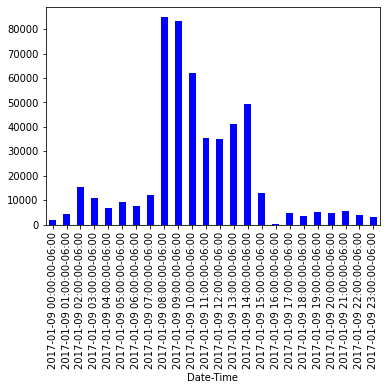

In [34]:
df.set_index("Date-Time", drop=False, inplace=True)
df = df["Date-Time"].groupby(pd.Grouper(freq='60Min')).count()
ax = df.plot(kind='bar', color='b')
ticklabels = df.index.strftime('%H:%Mh')
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
plt.show()

In [5]:
df.loc[[1,2,3],"Date-Time"].values

array(['2017-01-06 00:00:00.881855999-06:00',
       '2017-01-06 00:00:00.882763384-06:00',
       '2017-01-06 00:00:01.025801969-06:00'], dtype=object)

In [36]:
def TW_avg(df, datetime_col, keys, timestamp_cutoffs, fillforward=True):
    # Forward Fill    
    if fillforward:
        for key in keys:
            df[key] = df[key].fillna(method='ffill')
            df['L1-'+key] = df[key].shift(1)

    # Form the interval groups based on the timestamps provided. The code doesn't automatically create any intervals at the 
    # begining and end of data. If desired the intervals should be explicitly passed to the function.
    df['Group'] = pd.cut(df[datetime_col], timestamp_cutoffs)
    df['Group Open'] = pd.IntervalIndex(df['Group']).get_level_values(0).left
    df['Group Close'] = pd.IntervalIndex(df['Group']).get_level_values(0).right

    # Forward Deltas
    df['F Delta'] = (df['Date-Time'].shift(-1)-df['Date-Time']).dt.total_seconds()
    df['F Delta 2'] = (df['Group Close']-df[datetime_col]).dt.total_seconds()
    df['F Delta 3'] = np.where((df['F Delta'] < df['F Delta 2']) | (df['F Delta'].isna()), df['F Delta'], df['F Delta 2'])

    # Backward Deltas
    df['B Delta'] = df['F Delta'].shift(1)
    df['B Delta 2'] = (df[datetime_col] - df['Group Open']).dt.total_seconds()
    df['B Delta 3'] = np.where((df['B Delta'] < df['B Delta 2']) | (df['B Delta'].isna()), np.NaN, df['B Delta 2'])

    # Variable * Delta
    for key in keys:
        df[key + ' * Delta'] = df[key] * df['F Delta 3']
        df['L1-' + key + ' * Delta'] = df['L1-' + key] * df['B Delta 3']

    # Group dataframe based on cutoffs
    df_grouped =  df.groupby(df['Group'])

    # Emoty dataframe for aggregate measures
    df_agg = pd.DataFrame()

    # Open and Close of Variables
    for key in keys:
        df_agg[key + ' * Delta'] = df_grouped[key + ' * Delta'].sum()
        df_agg[key + ' * Delta Open'] = df_grouped['L1-' + key + ' * Delta'].sum()
        df_agg['Time Delta'] = df_grouped['F Delta 3'].sum() + df_grouped['B Delta 3'].sum()

    df_agg['Bar Open Time Stamp'] =  pd.IntervalIndex(df_agg.index.get_level_values(0)).left
    df_agg['Bar Close Time Stamp'] =  pd.IntervalIndex(df_agg.index.get_level_values(0)).right

    for key in keys:
        df_agg['TW Avg '+ key] = (df_agg[key + ' * Delta'] + df_agg[key + ' * Delta Open'] ) / df_agg['Time Delta']
 
    return_cols = ['Time Delta', 'Bar Open Time Stamp', 'Bar Close Time Stamp'] + ['TW Avg '+key for key in keys]

    return df_agg[return_cols]